## Install TensorTrade

In [ ]:
!python3 -m pip install -e .. -U

## Setup Data Fetching

In [2]:
import ssl
import pandas as pd

from tensortrade.utils import CryptoDataDownload

ssl._create_default_https_context = ssl._create_unverified_context # Only used if pandas gives a SSLError

cdd = CryptoDataDownload()

In [3]:
data = pd.concat([
    cdd.fetch("Coinbase", "USD", "BTC", "1h").add_prefix("BTC:"),
    cdd.fetch("Coinbase", "USD", "ETH", "1h").add_prefix("ETH:")
], axis=1)
data = data.drop(["ETH:date"], axis=1)
data = data.rename({"BTC:date": "date"}, axis=1)

In [4]:
data.head()

,date,BTC:open,BTC:high,BTC:low,BTC:close,BTC:volume,ETH:open,ETH:high,ETH:low,ETH:close,ETH:volume
0,2017-07-01 11:00:00,2505.56,2513.38,2495.12,2509.17,287000.32,279.98,279.99,272.1,275.01,679358.87
1,2017-07-01 12:00:00,2509.17,2512.87,2484.99,2488.43,393142.50,275.01,275.01,271.0,274.83,824362.87
2,2017-07-01 13:00:00,2488.43,2488.43,2454.40,2454.43,693254.01,274.83,274.93,265.0,268.79,3010787.99
3,2017-07-01 14:00:00,2454.43,2473.93,2450.83,2459.35,712864.80,268.79,269.90,265.0,265.74,1702536.85
4,2017-07-01 15:00:00,2459.35,2475.00,2450.00,2467.83,682105.41,265.74,272.74,265.0,272.57,1500282.55


## Create features with the data module

In [32]:
from tensortrade.data import Node, Module, DataFeed, Stream, Select


def rsi(price: Node, period: float):
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)


def macd(price: Node, fast: float, slow: float, signal: float) -> Node:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal


features = []
for c in data.columns[1:]:
    s = Stream(list(data[c])).rename(data[c].name)
    features += [s]

btc_close = Select("BTC:close")(*features)
eth_close = Select("ETH:close")(*features)

features += [
    rsi(btc_close, period=20).rename("BTC:rsi"),
    macd(btc_close, fast=10, slow=50, signal=5).rename("BTC:macd"),
    rsi(eth_close, period=20).rename("ETH:rsi"),
    macd(eth_close, fast=10, slow=50, signal=5).rename("ETH:macd")
]
        
feed = DataFeed(features)
feed.compile()

In [33]:
feed.next()

{'BTC:open': 2505.56,
 'BTC:high': 2513.38,
 'BTC:low': 2495.12,
 'BTC:close': 2509.17,
 'BTC:volume': 287000.32,
 'ETH:open': 279.98,
 'ETH:high': 279.99,
 'ETH:low': 272.1,
 'ETH:close': 275.01,
 'ETH:volume': 679358.87,
 'BTC:rsi': nan,
 'BTC:macd': 0.0,
 'ETH:rsi': nan,
 'ETH:macd': 0.0}

## Setup Trading Environment

In [40]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC, ETH
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment


coinbase = Exchange("coinbase", service=execute_order)(
    Stream(list(data["BTC:close"])).rename("USD-BTC"),
    Stream(list(data["ETH:close"])).rename("USD-ETH")
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
    Wallet(coinbase, 5 * ETH),
])

env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    use_internal=False,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    window_size=20
)

## Example Data Feed Observation

Even though this observation contains data from the internal data feed, since `use_internal=False` this data will not be provided as input to the observation history. The data that will be added to observation history of the environment will strictly be the nodes that have been included into the data feed that has been provided as a parameter to the trading environment.

In [41]:
env.feed.next()

{'BTC:open': 2505.56,
 'BTC:high': 2513.38,
 'BTC:low': 2495.12,
 'BTC:close': 2509.17,
 'BTC:volume': 287000.32,
 'ETH:open': 279.98,
 'ETH:high': 279.99,
 'ETH:low': 272.1,
 'ETH:close': 275.01,
 'ETH:volume': 679358.87,
 'BTC:rsi': 0.0,
 'BTC:macd': 0.7571659584890904,
 'ETH:rsi': 0.0,
 'ETH:macd': 0.006571353545266716,
 'coinbase:/USD-BTC': 2509.17,
 'coinbase:/USD-ETH': 275.01,
 'coinbase:/USD:/free': 10000.0,
 'coinbase:/USD:/locked': 0.0,
 'coinbase:/USD:/total': 10000.0,
 'coinbase:/BTC:/free': 10.0,
 'coinbase:/BTC:/locked': 0.0,
 'coinbase:/BTC:/total': 10.0,
 'coinbase:/BTC:/worth': 25091.7,
 'coinbase:/ETH:/free': 5.0,
 'coinbase:/ETH:/locked': 0.0,
 'coinbase:/ETH:/total': 5.0,
 'coinbase:/ETH:/worth': 1375.05,
 'net_worth': 36466.75}

## Setup and Train DQN Agent

In [ ]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

agent.train(n_steps=200, save_path="examples/agents/")

## Plot Performance

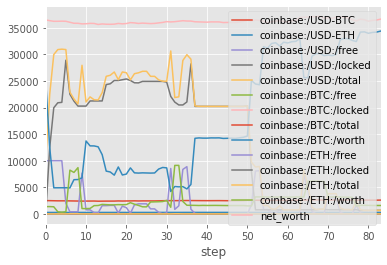

In [43]:
%matplotlib inline

portfolio.performance.plot()

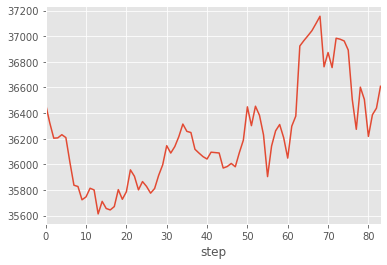

In [44]:
portfolio.performance.net_worth.plot()

## Setup and Train Parallel DQN Agent

In [ ]:
from tensortrade.agents import ParallelDQNAgent

def create_env():
    
    env = TradingEnvironment(
        feed=feed,
        portfolio=portfolio,
        action_scheme='managed-risk',
        reward_scheme='risk-adjusted',
        window_size=20
    )
    
    return env

agent = ParallelDQNAgent(create_env)

agent.train(n_envs=4, n_steps=200, save_path="examples/agents/")